# Clustering des Employés par Performance
## Segmentation automatique basée sur le nombre de commandes

Ce notebook effectue un clustering des employés pour identifier différents groupes de performance en utilisant plusieurs méthodes de détermination automatique du nombre optimal de clusters.

Afin d’analyser la performance des employés dans le temps et d’identifier les périodes de forte activité, l’identifiant séquentiel (id_seqEmployee) est privilégié. Ce choix permet une analyse temporelle fine et garantit une meilleure traçabilité des performances par période, contrairement à l’identifiant statique de l’employé.

### 1. Importation des bibliothèques

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Configuration pour un meilleur affichage
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Bibliothèques chargées avec succès!")

✅ Bibliothèques chargées avec succès!


### 2. Chargement des données

In [17]:
# Chargement des trois tables CSV
fait = pd.read_csv('../data/Fait_Commandes.csv')
dim_client = pd.read_csv('../data/Dim_Client.csv')
dim_employee = pd.read_csv('../data/Dim_Employee.csv')

print("📊 Données chargées:")
print(f"Fait: {fait.shape}")
print(f"Dim_Client: {dim_client.shape}")
print(f"Dim_Employee: {dim_employee.shape}")

📊 Données chargées:
Fait: (4938, 6)
Dim_Client: (120, 6)
Dim_Employee: (58, 8)


### 3. Préparation des données

In [18]:
# Renommage des colonnes si nécessaire
fait = fait.rename(columns={
    'Dim_Client.id_seqClient': 'id_seqClient',
    'Dim_Employee.id_seqEmployee': 'id_seqEmployee',
    'Somme de nbr_commandes_livrees': 'nbr_commande_livrees',
    'Somme de nbr_commandes_non_livrees': 'nbr_commande_non_livrees'
})

# Calcul du total des commandes
fait['Total_Commandes'] = fait['nbr_commande_livrees'] + fait['nbr_commande_non_livrees']

# Jointure avec la dimension Employee
dataset = fait.merge(dim_employee[['id_seqEmployee', 'Nom', 'Prenom', 'Region']], 
                     on='id_seqEmployee', 
                     how='left')

dataset = dataset.drop_duplicates()

print("Dataset préparé:")
print(dataset.head())

Dataset préparé:
   idSeqFait  Dim_Temps.id_temps  id_seqClient  id_seqEmployee  \
0          1                   1            85              17   
1          2                   1            85              18   
2          3                   1            85              19   
3          4                   1            85              20   
4          5                   1            85              21   

   nbr_commande_livrees  nbr_commande_non_livrees  Total_Commandes       Nom  \
0                     1                         0                1  Buchanan   
1                     1                         0                1  Buchanan   
2                     1                         0                1  Buchanan   
3                     1                         0                1  Buchanan   
4                     1                         0                1  Buchanan   

   Prenom   Region  
0  Steven  Eastern  
1  Steven  Eastern  
2  Steven  Eastern  
3  Steven  Eastern  


### 4. Agrégation par employé

In [19]:
# Agrégation : Total des commandes par employé
employes_agg = dataset.groupby(['id_seqEmployee', 'Nom', 'Prenom', 'Region']).agg({
    'Total_Commandes': 'sum',
    'nbr_commande_livrees': 'sum',
    'nbr_commande_non_livrees': 'sum'
}).reset_index()

# Calcul de métriques supplémentaires
employes_agg['Taux_Livraison'] = (
    employes_agg['nbr_commande_livrees'] / employes_agg['Total_Commandes'] * 100
).round(2)

employes_agg['Nom_Complet'] = employes_agg['Prenom'] + ' ' + employes_agg['Nom']

print(f"\n📊 Nombre d'employés uniques: {len(employes_agg)}")
print("\nAperçu des données agrégées:")
print(employes_agg.head(10))

print("\nStatistiques descriptives:")
print(employes_agg[['Total_Commandes', 'Taux_Livraison']].describe())


📊 Nombre d'employés uniques: 49

Aperçu des données agrégées:
   id_seqEmployee        Nom  Prenom    Region  Total_Commandes  \
0               1    Davolio   Nancy   Eastern              135   
1               2    Davolio   Nancy   Eastern              135   
2               3     Fuller  Andrew   Eastern              100   
3               4     Fuller  Andrew   Eastern              100   
4               5     Fuller  Andrew   Eastern              100   
5               6     Fuller  Andrew   Eastern              100   
6               7     Fuller  Andrew   Eastern              100   
7               8     Fuller  Andrew   Eastern              100   
8               9     Fuller  Andrew   Eastern              100   
9              10  Leverling   Janet  Southern              133   

   nbr_commande_livrees  nbr_commande_non_livrees  Taux_Livraison  \
0                   125                        10           92.59   
1                   125                        10           9

### 5. Visualisation initiale - Nuage de points

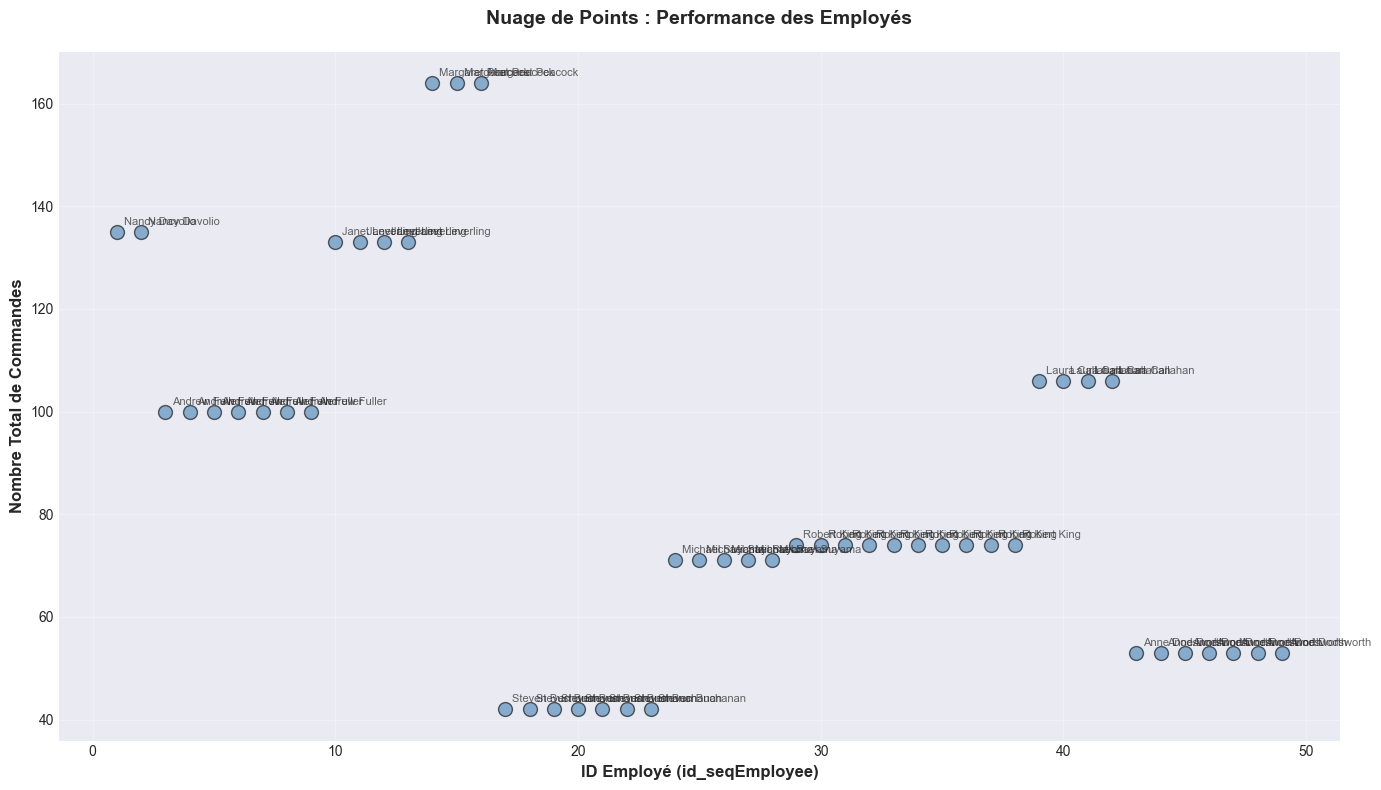

In [20]:
# Nuage de points : id_seqEmployee vs Total_Commandes
plt.figure(figsize=(14, 8))
plt.scatter(employes_agg['id_seqEmployee'], 
           employes_agg['Total_Commandes'],
           s=100, alpha=0.6, c='steelblue', edgecolors='black', linewidth=1)

# Annoter les points avec les noms
for idx, row in employes_agg.iterrows():
    plt.annotate(row['Nom_Complet'], 
                (row['id_seqEmployee'], row['Total_Commandes']),
                fontsize=8, alpha=0.7,
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('ID Employé (id_seqEmployee)', fontsize=12, fontweight='bold')
plt.ylabel('Nombre Total de Commandes', fontsize=12, fontweight='bold')
plt.title('Nuage de Points : Performance des Employés', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6. Préparation des données pour le clustering

In [21]:
# Sélection des features pour le clustering
# On utilise id_seqEmployee et Total_Commandes
X = employes_agg[['id_seqEmployee', 'Total_Commandes']].values

print(f"Shape des données: {X.shape}")
print(f"\nPremières lignes:")
print(X[:5])

# Normalisation des données (important pour le clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nDonnées normalisées (premiers exemples):")
print(X_scaled[:5])

Shape des données: (49, 2)

Premières lignes:
[[  1 135]
 [  2 135]
 [  3 100]
 [  4 100]
 [  5 100]]

Données normalisées (premiers exemples):
[[-1.69705627  1.438465  ]
 [-1.6263456   1.438465  ]
 [-1.55563492  0.42616813]
 [-1.48492424  0.42616813]
 [-1.41421356  0.42616813]]


### 7. Méthode 1 : Elbow Method (Méthode du Coude)

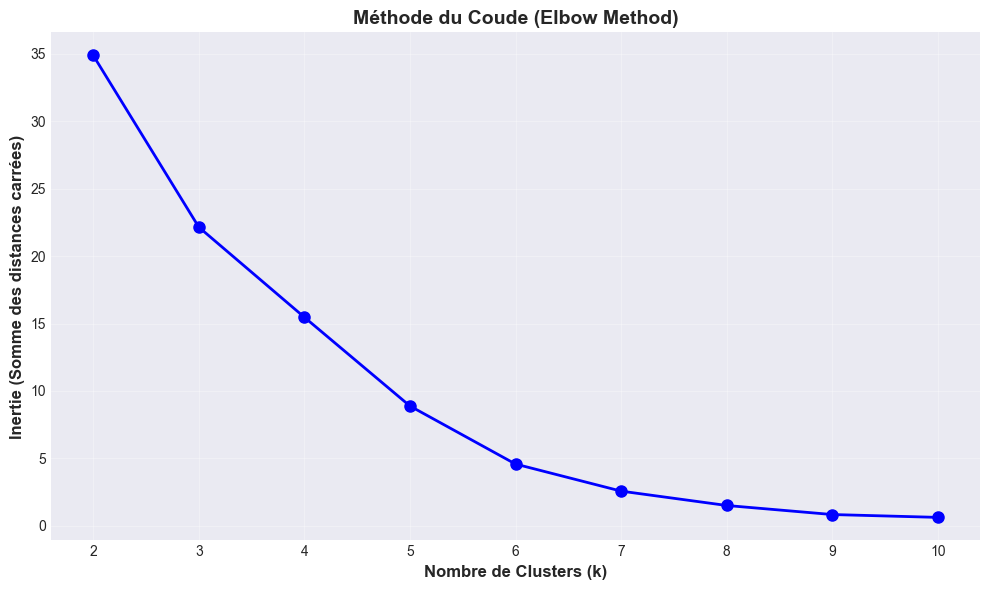

📊 Inertie pour chaque nombre de clusters:
k=2: 34.87
k=3: 22.14
k=4: 15.47
k=5: 8.89
k=6: 4.59
k=7: 2.58
k=8: 1.51
k=9: 0.84
k=10: 0.63


In [22]:
# Test de différents nombres de clusters
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Visualisation de la méthode du coude
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Nombre de Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Inertie (Somme des distances carrées)', fontsize=12, fontweight='bold')
plt.title('Méthode du Coude (Elbow Method)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

print("📊 Inertie pour chaque nombre de clusters:")
for k, inertia in zip(K_range, inertias):
    print(f"k={k}: {inertia:.2f}")

### 8. Méthode 2 : Silhouette Score

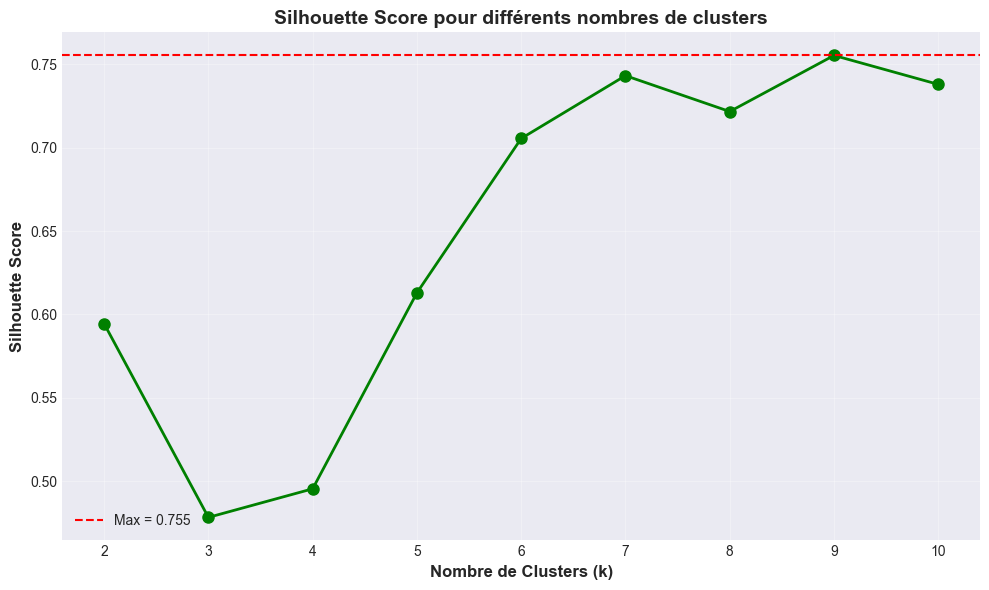

📊 Silhouette Score pour chaque nombre de clusters:
k=2: 0.5944
k=3: 0.4783
k=4: 0.4954
k=5: 0.6129
k=6: 0.7055
k=7: 0.7432
k=8: 0.7216
k=9: 0.7553
k=10: 0.7379

✅ Nombre optimal de clusters (Silhouette): 9


In [23]:
# Calcul du Silhouette Score pour différents k
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Nombre de Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=12, fontweight='bold')
plt.title('Silhouette Score pour différents nombres de clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.axhline(y=max(silhouette_scores), color='r', linestyle='--', label=f'Max = {max(silhouette_scores):.3f}')
plt.legend()
plt.tight_layout()
plt.show()

# Trouver le k optimal
optimal_k_silhouette = K_range[silhouette_scores.index(max(silhouette_scores))]

print("📊 Silhouette Score pour chaque nombre de clusters:")
for k, score in zip(K_range, silhouette_scores):
    print(f"k={k}: {score:.4f}")

print(f"\n✅ Nombre optimal de clusters (Silhouette): {optimal_k_silhouette}")

### 9. Méthode 3 : Davies-Bouldin Index

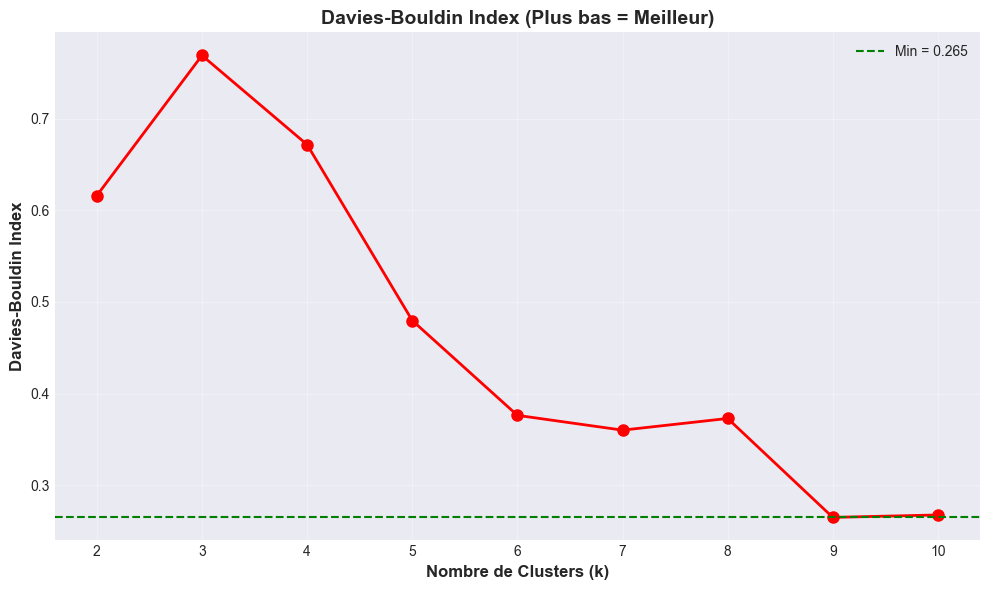

📊 Davies-Bouldin Index pour chaque nombre de clusters:
k=2: 0.6161
k=3: 0.7691
k=4: 0.6717
k=5: 0.4797
k=6: 0.3762
k=7: 0.3600
k=8: 0.3728
k=9: 0.2648
k=10: 0.2674

✅ Nombre optimal de clusters (Davies-Bouldin): 9


In [24]:
# Calcul du Davies-Bouldin Index (plus bas = meilleur)
db_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = davies_bouldin_score(X_scaled, labels)
    db_scores.append(score)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(K_range, db_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Nombre de Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
plt.title('Davies-Bouldin Index (Plus bas = Meilleur)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.axhline(y=min(db_scores), color='g', linestyle='--', label=f'Min = {min(db_scores):.3f}')
plt.legend()
plt.tight_layout()
plt.show()

optimal_k_db = K_range[db_scores.index(min(db_scores))]

print("📊 Davies-Bouldin Index pour chaque nombre de clusters:")
for k, score in zip(K_range, db_scores):
    print(f"k={k}: {score:.4f}")

print(f"\n✅ Nombre optimal de clusters (Davies-Bouldin): {optimal_k_db}")

### 10. Méthode 4 : Calinski-Harabasz Index

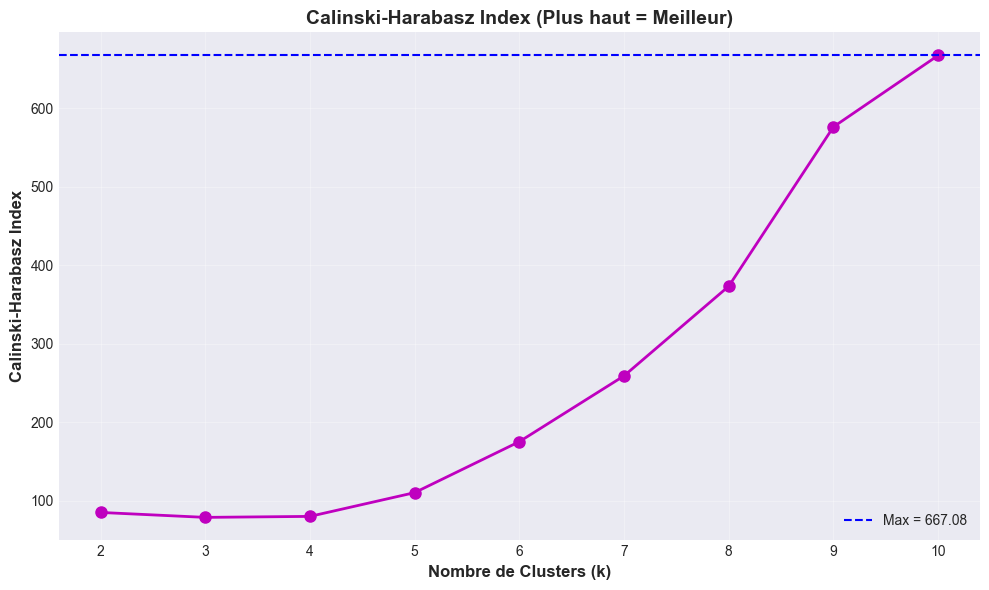

📊 Calinski-Harabasz Index pour chaque nombre de clusters:
k=2: 85.08
k=3: 78.79
k=4: 80.05
k=5: 110.30
k=6: 175.21
k=7: 259.02
k=8: 373.17
k=9: 576.08
k=10: 667.08

✅ Nombre optimal de clusters (Calinski-Harabasz): 10


In [25]:
# Calcul du Calinski-Harabasz Index (plus haut = meilleur)
ch_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = calinski_harabasz_score(X_scaled, labels)
    ch_scores.append(score)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(K_range, ch_scores, 'mo-', linewidth=2, markersize=8)
plt.xlabel('Nombre de Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Calinski-Harabasz Index', fontsize=12, fontweight='bold')
plt.title('Calinski-Harabasz Index (Plus haut = Meilleur)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.axhline(y=max(ch_scores), color='b', linestyle='--', label=f'Max = {max(ch_scores):.2f}')
plt.legend()
plt.tight_layout()
plt.show()

optimal_k_ch = K_range[ch_scores.index(max(ch_scores))]

print("📊 Calinski-Harabasz Index pour chaque nombre de clusters:")
for k, score in zip(K_range, ch_scores):
    print(f"k={k}: {score:.2f}")

print(f"\n✅ Nombre optimal de clusters (Calinski-Harabasz): {optimal_k_ch}")

### 11. Synthèse : Détermination automatique du nombre optimal de clusters

In [26]:
# Résumé des méthodes
print("="*70)
print("SYNTHÈSE : NOMBRE OPTIMAL DE CLUSTERS")
print("="*70)
print(f"\n1. Silhouette Score (max)        : k = {optimal_k_silhouette}")
print(f"2. Davies-Bouldin Index (min)    : k = {optimal_k_db}")
print(f"3. Calinski-Harabasz Index (max) : k = {optimal_k_ch}")
print("\n4. Méthode du Coude              : Observez le graphique pour identifier le 'coude'")

# Vote majoritaire
from collections import Counter
votes = [optimal_k_silhouette, optimal_k_db, optimal_k_ch]
vote_count = Counter(votes)
k_final = vote_count.most_common(1)[0][0]

print("\n" + "="*70)
print(f"🏆 DÉCISION AUTOMATIQUE : k = {k_final} clusters")
print("="*70)
print(f"\nBasé sur le vote majoritaire des méthodes statistiques.")

# Tableau récapitulatif
summary_df = pd.DataFrame({
    'k': list(K_range),
    'Silhouette': silhouette_scores,
    'Davies-Bouldin': db_scores,
    'Calinski-Harabasz': ch_scores
})

print("\n📊 Tableau récapitulatif de tous les scores:")
print(summary_df.to_string(index=False))

SYNTHÈSE : NOMBRE OPTIMAL DE CLUSTERS

1. Silhouette Score (max)        : k = 9
2. Davies-Bouldin Index (min)    : k = 9
3. Calinski-Harabasz Index (max) : k = 10

4. Méthode du Coude              : Observez le graphique pour identifier le 'coude'

🏆 DÉCISION AUTOMATIQUE : k = 9 clusters

Basé sur le vote majoritaire des méthodes statistiques.

📊 Tableau récapitulatif de tous les scores:
 k  Silhouette  Davies-Bouldin  Calinski-Harabasz
 2    0.594421        0.616124          85.084058
 3    0.478265        0.769116          78.791280
 4    0.495399        0.671718          80.045440
 5    0.612938        0.479713         110.303048
 6    0.705495        0.376174         175.214268
 7    0.743169        0.360010         259.023047
 8    0.721643        0.372767         373.174989
 9    0.755289        0.264771         576.081407
10    0.737927        0.267407         667.076416


### 12. Application du clustering avec k optimal

In [27]:
# Appliquer KMeans avec le nombre optimal de clusters
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
employes_agg['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Ajouter les centres des clusters (dénormalisés)
centers_scaled = kmeans_final.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

print(f"✅ Clustering effectué avec k = {k_final}")
print(f"\nCentres des clusters (valeurs originales):")
for i, center in enumerate(centers_original):
    print(f"Cluster {i}: ID_Employee = {center[0]:.2f}, Total_Commandes = {center[1]:.2f}")

print("\nRépartition des employés par cluster:")
print(employes_agg['Cluster'].value_counts().sort_index())

✅ Clustering effectué avec k = 9

Centres des clusters (valeurs originales):
Cluster 0: ID_Employee = 20.00, Total_Commandes = 42.00
Cluster 1: ID_Employee = 6.00, Total_Commandes = 100.00
Cluster 2: ID_Employee = 46.00, Total_Commandes = 53.00
Cluster 3: ID_Employee = 34.50, Total_Commandes = 74.00
Cluster 4: ID_Employee = 11.50, Total_Commandes = 133.00
Cluster 5: ID_Employee = 15.00, Total_Commandes = 164.00
Cluster 6: ID_Employee = 27.00, Total_Commandes = 71.86
Cluster 7: ID_Employee = 40.50, Total_Commandes = 106.00
Cluster 8: ID_Employee = 1.50, Total_Commandes = 135.00

Répartition des employés par cluster:
Cluster
0    7
1    7
2    7
3    8
4    4
5    3
6    7
7    4
8    2
Name: count, dtype: int64


### 13. Visualisation finale du clustering

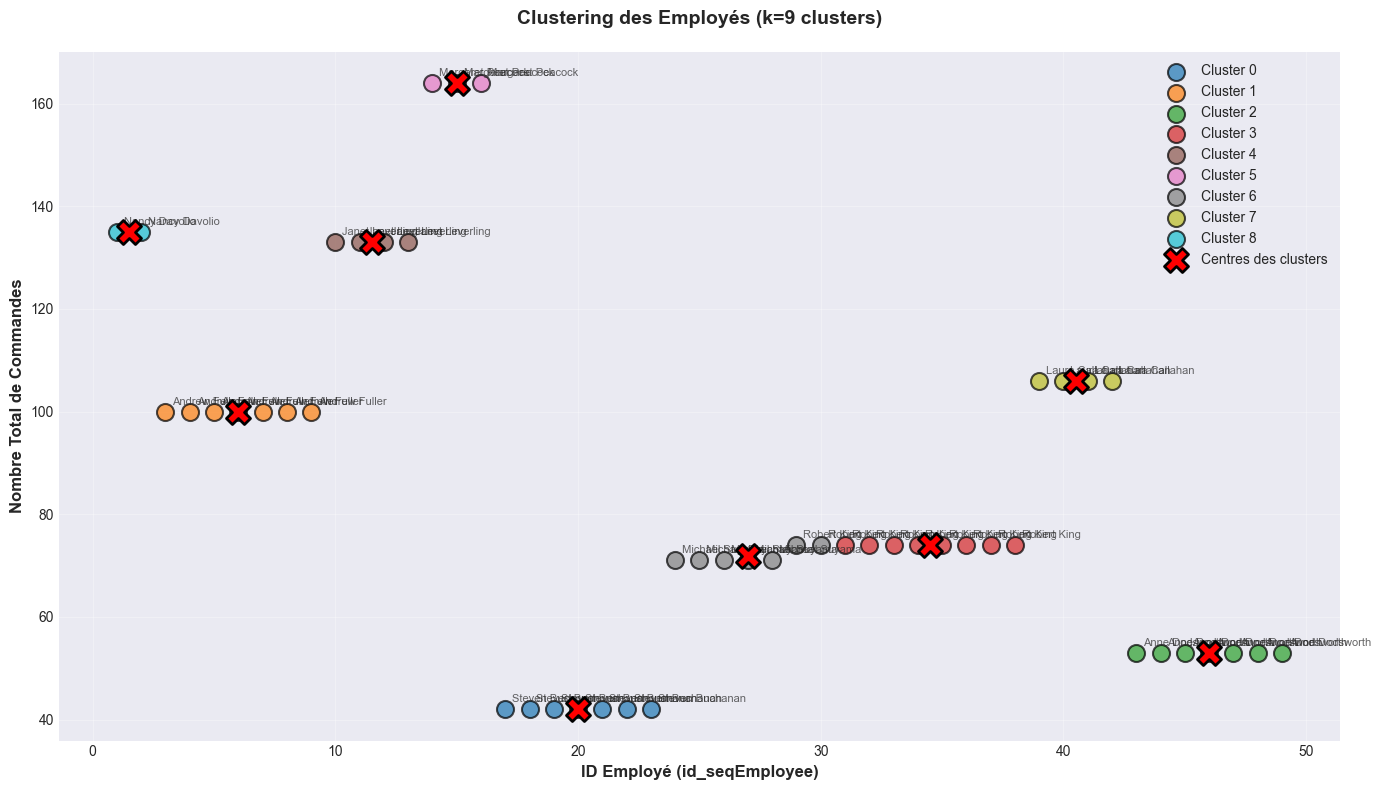

In [28]:
# Nuage de points avec clusters colorés
plt.figure(figsize=(14, 8))

# Palette de couleurs
colors = plt.cm.tab10(np.linspace(0, 1, k_final))

# Plot des points par cluster
for i in range(k_final):
    cluster_data = employes_agg[employes_agg['Cluster'] == i]
    plt.scatter(cluster_data['id_seqEmployee'], 
               cluster_data['Total_Commandes'],
               s=150, alpha=0.7, c=[colors[i]], 
               edgecolors='black', linewidth=1.5,
               label=f'Cluster {i}')

# Plot des centres de clusters
plt.scatter(centers_original[:, 0], centers_original[:, 1],
           s=300, c='red', marker='X', edgecolors='black', linewidth=2,
           label='Centres des clusters', zorder=5)

# Annoter les points
for idx, row in employes_agg.iterrows():
    plt.annotate(row['Nom_Complet'], 
                (row['id_seqEmployee'], row['Total_Commandes']),
                fontsize=8, alpha=0.7,
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('ID Employé (id_seqEmployee)', fontsize=12, fontweight='bold')
plt.ylabel('Nombre Total de Commandes', fontsize=12, fontweight='bold')
plt.title(f'Clustering des Employés (k={k_final} clusters)', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 14. Analyse détaillée des clusters

In [29]:
# Statistiques par cluster
print("="*70)
print("ANALYSE DÉTAILLÉE DES CLUSTERS")
print("="*70)

for i in range(k_final):
    cluster_data = employes_agg[employes_agg['Cluster'] == i]
    print(f"\n{'='*70}")
    print(f"CLUSTER {i}")
    print(f"{'='*70}")
    print(f"Nombre d'employés: {len(cluster_data)}")
    print(f"\nStatistiques des commandes:")
    print(f"  - Moyenne: {cluster_data['Total_Commandes'].mean():.2f}")
    print(f"  - Médiane: {cluster_data['Total_Commandes'].median():.2f}")
    print(f"  - Min: {cluster_data['Total_Commandes'].min():.2f}")
    print(f"  - Max: {cluster_data['Total_Commandes'].max():.2f}")
    print(f"  - Écart-type: {cluster_data['Total_Commandes'].std():.2f}")
    
    print(f"\nTaux de livraison moyen: {cluster_data['Taux_Livraison'].mean():.2f}%")
    
    print(f"\nEmployés dans ce cluster:")
    for idx, row in cluster_data.iterrows():
        print(f"  - {row['Nom_Complet']:20s} | ID: {row['id_seqEmployee']:3d} | Commandes: {row['Total_Commandes']:5.0f} | Livraison: {row['Taux_Livraison']:5.2f}%")

ANALYSE DÉTAILLÉE DES CLUSTERS

CLUSTER 0
Nombre d'employés: 7

Statistiques des commandes:
  - Moyenne: 42.00
  - Médiane: 42.00
  - Min: 42.00
  - Max: 42.00
  - Écart-type: 0.00

Taux de livraison moyen: 100.00%

Employés dans ce cluster:
  - Steven Buchanan      | ID:  17 | Commandes:    42 | Livraison: 100.00%
  - Steven Buchanan      | ID:  18 | Commandes:    42 | Livraison: 100.00%
  - Steven Buchanan      | ID:  19 | Commandes:    42 | Livraison: 100.00%
  - Steven Buchanan      | ID:  20 | Commandes:    42 | Livraison: 100.00%
  - Steven Buchanan      | ID:  21 | Commandes:    42 | Livraison: 100.00%
  - Steven Buchanan      | ID:  22 | Commandes:    42 | Livraison: 100.00%
  - Steven Buchanan      | ID:  23 | Commandes:    42 | Livraison: 100.00%

CLUSTER 1
Nombre d'employés: 7

Statistiques des commandes:
  - Moyenne: 100.00
  - Médiane: 100.00
  - Min: 100.00
  - Max: 100.00
  - Écart-type: 0.00

Taux de livraison moyen: 95.00%

Employés dans ce cluster:
  - Andrew Fuller  

### 15. Profils des clusters

In [30]:
# Créer des profils de clusters
cluster_profiles = employes_agg.groupby('Cluster').agg({
    'Total_Commandes': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'Taux_Livraison': 'mean'
}).round(2)

cluster_profiles.columns = ['_'.join(col).strip() for col in cluster_profiles.columns.values]
cluster_profiles = cluster_profiles.rename(columns={
    'Total_Commandes_count': 'Nb_Employes',
    'Total_Commandes_mean': 'Commandes_Moyenne',
    'Total_Commandes_median': 'Commandes_Mediane',
    'Total_Commandes_std': 'Commandes_Ecart_Type',
    'Total_Commandes_min': 'Commandes_Min',
    'Total_Commandes_max': 'Commandes_Max',
    'Taux_Livraison_mean': 'Taux_Livraison_Moyen'
})

print("\n📊 PROFILS DES CLUSTERS:")
print(cluster_profiles)

# Interpréter les clusters
print("\n" + "="*70)
print("INTERPRÉTATION DES CLUSTERS")
print("="*70)

for i in range(k_final):
    avg_commandes = cluster_profiles.loc[i, 'Commandes_Moyenne']
    nb_employes = int(cluster_profiles.loc[i, 'Nb_Employes'])
    print(f"  - {nb_employes} employé(s)")
    print(f"  - Moyenne de {avg_commandes:.0f} commandes par employé")


📊 PROFILS DES CLUSTERS:
         Nb_Employes  Commandes_Moyenne  Commandes_Mediane  \
Cluster                                                      
0                  7              42.00               42.0   
1                  7             100.00              100.0   
2                  7              53.00               53.0   
3                  8              74.00               74.0   
4                  4             133.00              133.0   
5                  3             164.00              164.0   
6                  7              71.86               71.0   
7                  4             106.00              106.0   
8                  2             135.00              135.0   

         Commandes_Ecart_Type  Commandes_Min  Commandes_Max  \
Cluster                                                       
0                        0.00             42             42   
1                        0.00            100            100   
2                        0.00           

### 16. Visualisations complémentaires

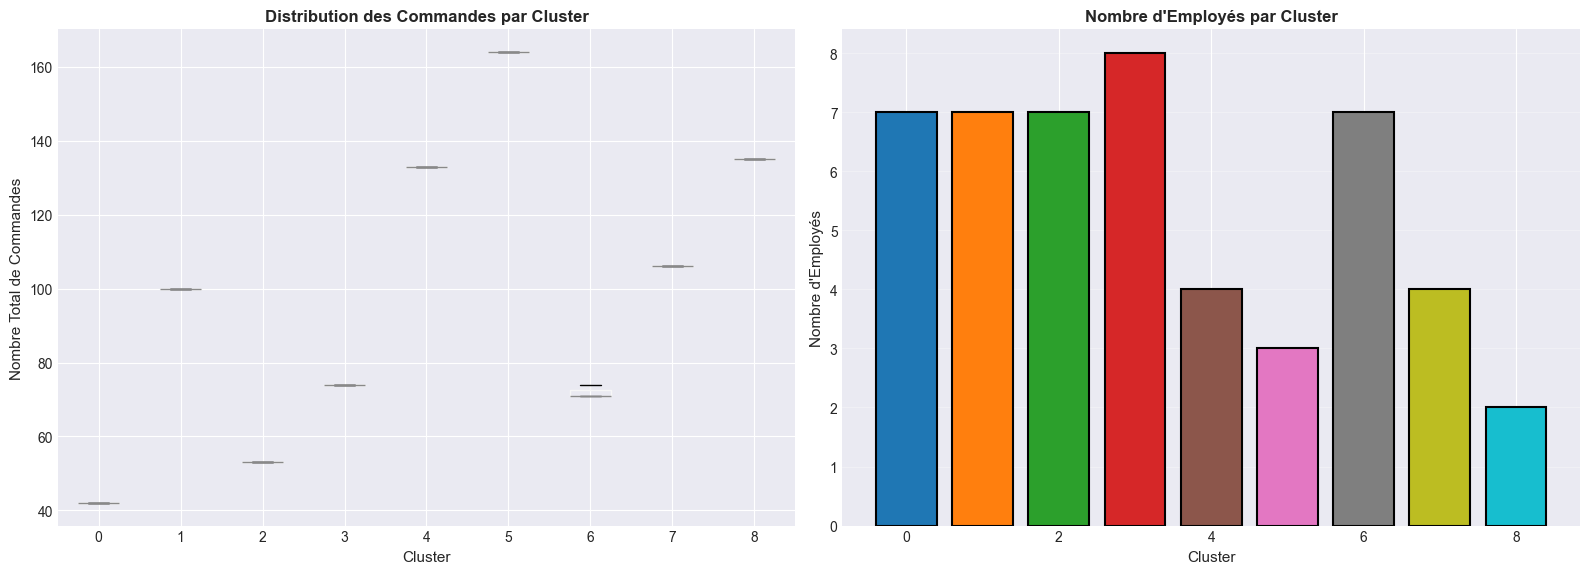

In [31]:
# Box plot par cluster
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot des commandes par cluster
employes_agg.boxplot(column='Total_Commandes', by='Cluster', ax=axes[0])
axes[0].set_title('Distribution des Commandes par Cluster', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('Nombre Total de Commandes', fontsize=11)
plt.sca(axes[0])
plt.xticks(range(1, k_final+1), range(k_final))

# Bar plot du nombre d'employés par cluster
cluster_counts = employes_agg['Cluster'].value_counts().sort_index()
axes[1].bar(cluster_counts.index, cluster_counts.values, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_title('Nombre d\'Employés par Cluster', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=11)
axes[1].set_ylabel('Nombre d\'Employés', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('')
plt.tight_layout()
plt.show()

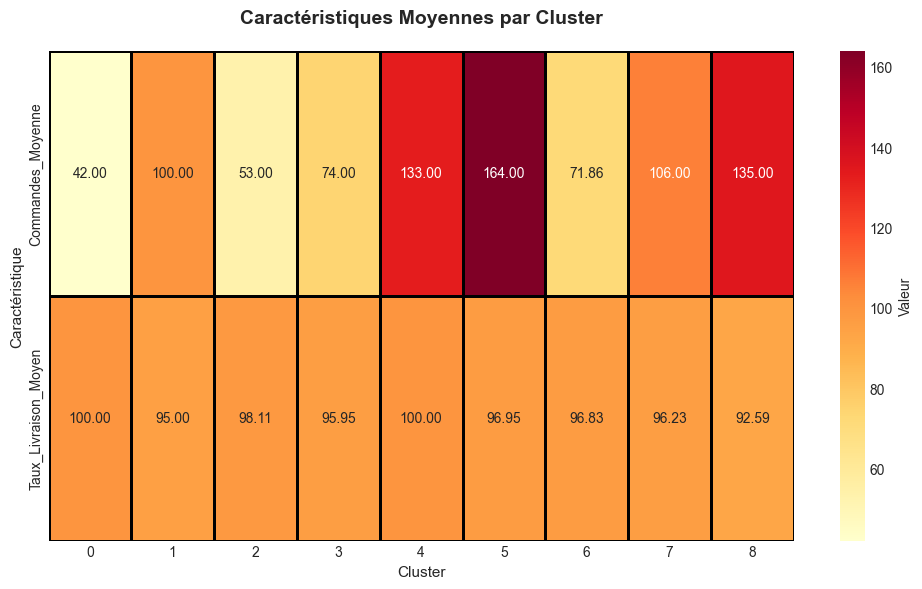

In [32]:
# Heatmap des caractéristiques par cluster
plt.figure(figsize=(10, 6))

heatmap_data = cluster_profiles[['Commandes_Moyenne', 'Taux_Livraison_Moyen']].T
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Valeur'}, linewidths=1, linecolor='black')

plt.title('Caractéristiques Moyennes par Cluster', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Caractéristique', fontsize=11)
plt.xlabel('Cluster', fontsize=11)
plt.tight_layout()
plt.show()

### 17. Dendrogramme (Clustering Hiérarchique)

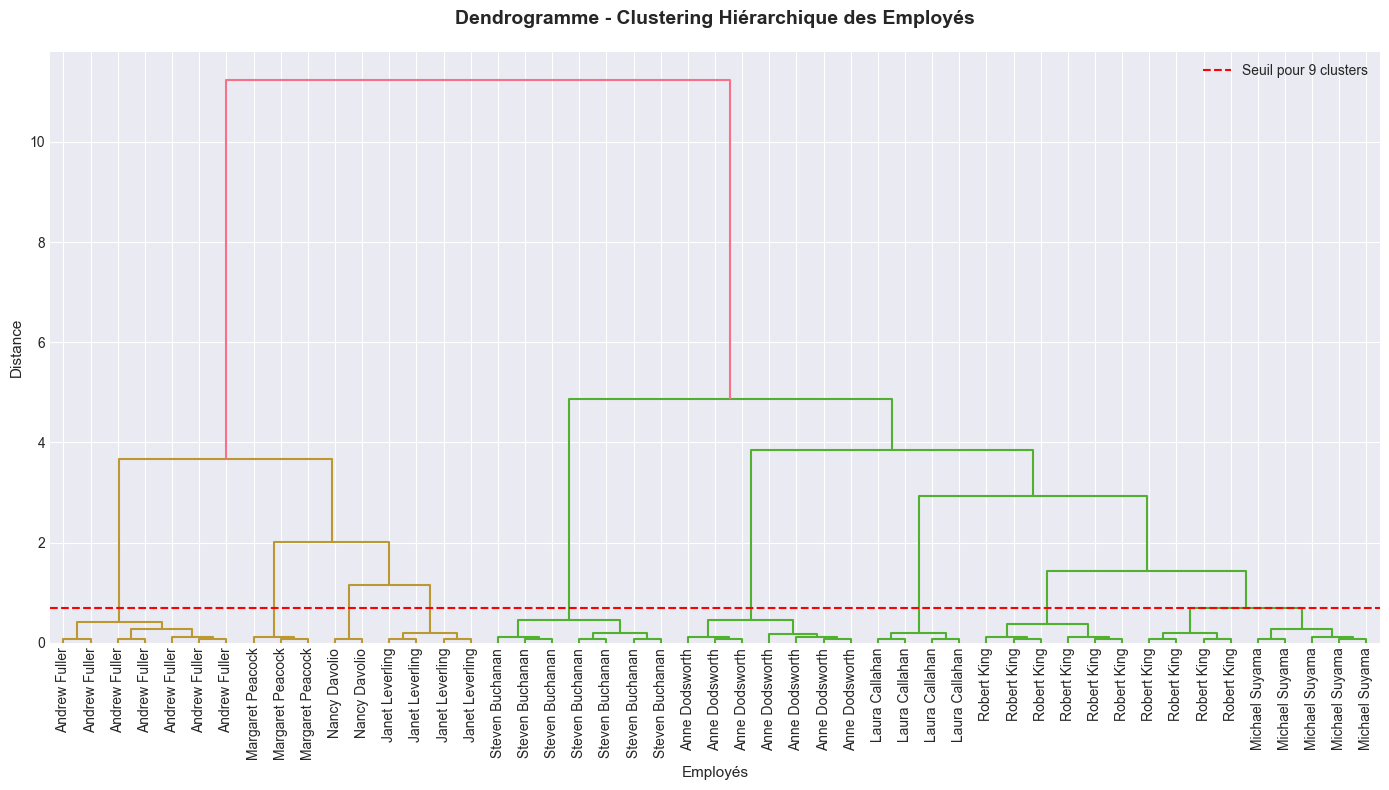


💡 Le dendrogramme montre comment les employés se regroupent hiérarchiquement.
La ligne rouge indique le seuil de coupe pour obtenir 9 clusters.


In [33]:
# Clustering hiérarchique pour visualiser les distances
plt.figure(figsize=(14, 8))

linkage_matrix = linkage(X_scaled, method='ward')

dendrogram(
    linkage_matrix,
    labels=employes_agg['Nom_Complet'].values,
    leaf_rotation=90,
    leaf_font_size=10
)

plt.title('Dendrogramme - Clustering Hiérarchique des Employés', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Employés', fontsize=11)
plt.ylabel('Distance', fontsize=11)
plt.axhline(y=linkage_matrix[-k_final, 2], color='r', linestyle='--', 
            label=f'Seuil pour {k_final} clusters')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n💡 Le dendrogramme montre comment les employés se regroupent hiérarchiquement.")
print(f"La ligne rouge indique le seuil de coupe pour obtenir {k_final} clusters.")

### 18. Export des résultats

In [34]:
# Préparer le dataset final avec les clusters
resultat_clustering = employes_agg[[
    'id_seqEmployee', 'Nom_Complet', 'Region', 
    'Total_Commandes', 'nbr_commande_livrees', 'nbr_commande_non_livrees',
    'Taux_Livraison', 'Cluster'
]].sort_values(['Cluster', 'Total_Commandes'], ascending=[True, False])

print("\n📊 Résultat final du clustering:")
print(resultat_clustering)

# Export en CSV (décommenter pour sauvegarder)
# resultat_clustering.to_csv('employes_clusters.csv', index=False)
# cluster_profiles.to_csv('profils_clusters.csv')

print("\n💾 Pour exporter les résultats, décommentez les lignes ci-dessus.")
print("\nFichiers qui seraient créés:")
print("  - employes_clusters.csv : Liste des employés avec leur cluster")
print("  - profils_clusters.csv : Statistiques par cluster")


📊 Résultat final du clustering:
    id_seqEmployee       Nom_Complet    Region  Total_Commandes  \
16              17   Steven Buchanan   Eastern               42   
17              18   Steven Buchanan   Eastern               42   
18              19   Steven Buchanan   Eastern               42   
19              20   Steven Buchanan   Eastern               42   
20              21   Steven Buchanan   Eastern               42   
21              22   Steven Buchanan   Eastern               42   
22              23   Steven Buchanan   Eastern               42   
2                3     Andrew Fuller   Eastern              100   
3                4     Andrew Fuller   Eastern              100   
4                5     Andrew Fuller   Eastern              100   
5                6     Andrew Fuller   Eastern              100   
6                7     Andrew Fuller   Eastern              100   
7                8     Andrew Fuller   Eastern              100   
8                9     Andrew

### 19. Recommandations et insights

In [35]:
print("="*70)
print("🎯 RECOMMANDATIONS BASÉES SUR LE CLUSTERING")
print("="*70)

for i in range(k_final):
    cluster_data = employes_agg[employes_agg['Cluster'] == i]
    avg_commandes = cluster_data['Total_Commandes'].mean()
    avg_livraison = cluster_data['Taux_Livraison'].mean()
    
    print(f"\n{'='*70}")
    print(f"Cluster {i}:")
    print(f"{'='*70}")
    
    if avg_commandes >= employes_agg['Total_Commandes'].quantile(0.75):
        print("✨ Groupe à HAUTE PERFORMANCE")
        print("\nRecommandations:")
        print("  • Identifier les meilleures pratiques de ce groupe")
        print("  • Les utiliser comme mentors pour former d'autres employés")
        print("  • Mettre en place un programme de reconnaissance")
        print("  • Analyser leurs méthodes de travail pour les standardiser")
    
    elif avg_commandes >= employes_agg['Total_Commandes'].quantile(0.50):
        print("📊 Groupe à PERFORMANCE MOYENNE")
        print("\nRecommandations:")
        print("  • Offrir des formations ciblées pour améliorer les performances")
        print("  • Mettre en place un système de mentorat avec le groupe haute performance")
        print("  • Identifier les obstacles spécifiques à ce groupe")
        print("  • Définir des objectifs de progression clairs")
    
    else:
        print("⚠️ Groupe à PERFORMANCE BASSE")
        print("\nRecommandations:")
        print("  • Analyser les causes de la faible performance (formation, ressources, motivation)")
        print("  • Mettre en place un plan d'amélioration individuel")
        print("  • Assigner un mentor ou coach")
        print("  • Évaluer si des changements organisationnels sont nécessaires")
    
    if avg_livraison < 90:
        print(f"\n⚠️ Attention: Taux de livraison moyen de {avg_livraison:.1f}%")
        print("  • Analyser les causes des commandes non livrées")
        print("  • Améliorer les processus de livraison")

print("\n" + "="*70)
print("🏆 CONCLUSION GÉNÉRALE")
print("="*70)
print(f"\nLe clustering automatique a identifié {k_final} groupes distincts d'employés.")
print("Cette segmentation permet de:")
print("  1. Personnaliser les stratégies de gestion par groupe")
print("  2. Optimiser l'allocation des ressources")
print("  3. Améliorer les performances globales de l'équipe")
print("  4. Identifier les talents à fort potentiel")
print("  5. Cibler les formations et le développement des compétences")

🎯 RECOMMANDATIONS BASÉES SUR LE CLUSTERING

Cluster 0:
⚠️ Groupe à PERFORMANCE BASSE

Recommandations:
  • Analyser les causes de la faible performance (formation, ressources, motivation)
  • Mettre en place un plan d'amélioration individuel
  • Assigner un mentor ou coach
  • Évaluer si des changements organisationnels sont nécessaires

Cluster 1:
📊 Groupe à PERFORMANCE MOYENNE

Recommandations:
  • Offrir des formations ciblées pour améliorer les performances
  • Mettre en place un système de mentorat avec le groupe haute performance
  • Identifier les obstacles spécifiques à ce groupe
  • Définir des objectifs de progression clairs

Cluster 2:
⚠️ Groupe à PERFORMANCE BASSE

Recommandations:
  • Analyser les causes de la faible performance (formation, ressources, motivation)
  • Mettre en place un plan d'amélioration individuel
  • Assigner un mentor ou coach
  • Évaluer si des changements organisationnels sont nécessaires

Cluster 3:
📊 Groupe à PERFORMANCE MOYENNE

Recommandations:
